In [1]:
# Importation des bibliothèques nécessaires
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

In [21]:
# 1. Téléchargement des données historiques
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'BRK-B', 'JNJ', 'V', 'NVDA']
benchmark_ticker = '^GSPC'  # S&P 500
start_date = "2015-01-01"
end_date = "2024-11-30"

# Téléchargement des données de clôture ajustée
data = yf.download(tickers + [benchmark_ticker], start=start_date, end=end_date)['Adj Close']
returns = data[tickers].pct_change().dropna()
sp500_returns = data[benchmark_ticker].pct_change().dropna()

# Séparation des périodes in-sample et out-of-sample
split_date = "2019-01-01"
returns_in = returns.loc[:split_date]
returns_out = returns.loc[split_date:]

[*********************100%%**********************]  10 of 10 completed


In [22]:
# 2. Fonction Markowitz avec coûts linéaires
def markowitz_linear(returns, lin_cost, risk_target):
    n = returns.shape[1]
    mu = returns.mean().values
    Sigma = returns.cov().values
    w = cvx.Variable(n)
    portfolio_return = mu @ w
    portfolio_risk = cvx.quad_form(w, Sigma)
    transaction_cost = lin_cost @ cvx.abs(w)
    objective = cvx.Maximize(portfolio_return - transaction_cost)
    constraints = [cvx.sum(w) == 1, portfolio_risk <= risk_target**2, w >= 0]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [23]:
# 2. Fonction Markowitz avec maximisation des rendements
def markowitz_max_return(returns):
    n = returns.shape[1]
    mu = returns.mean().values  # Rendements moyens des actifs
    # Variable d'optimisation
    w = cvx.Variable(n)
    # Fonction objectif : maximiser le rendement total
    objective = cvx.Maximize(mu @ w)
    # Contraintes : somme des poids = 1 et poids >= 0
    constraints = [
        cvx.sum(w) == 1,
        w >= 0
    ]
    # Résolution du problème d'optimisation
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [24]:
# 2. Fonction Markowitz maximisant l'utilité
def markowitz_utility(returns, risk_aversion):
    n = returns.shape[1]
    mu = returns.mean().values
    Sigma = returns.cov().values
    w = cvx.Variable(n)
    utility = mu @ w - risk_aversion / 2 * cvx.quad_form(w, Sigma)
    constraints = [cvx.sum(w) == 1, w >= 0]
    problem = cvx.Problem(cvx.Maximize(utility), constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [25]:
# 4. Fonction ERC
def computeERC(Sigma):
    Sigma = np.array(Sigma)
    n = np.shape(Sigma)[0]
    x0 = np.ones((n, 1)) / n
    x = x0 * 10
    var = np.diag(Sigma)
    Sx = Sigma.dot(x)
    convergence = False
    while not convergence:
        for i in range(n):
            alpha = var[i]
            beta = (Sx[i] - x[i] * var[i])[0]
            gamma_ = -1.0 / n
            x_tilde = (-beta + np.sqrt(beta**2 - 4 * alpha * gamma_)) / (2 * alpha)
            x[i] = x_tilde
            Sx = Sigma.dot(x)
        convergence = np.sum((x / np.sum(x) - x0 / np.sum(x0))**2) <= 1e-5
        x0 = x.copy()
    return (x / x.sum()).flatten()


In [26]:
# 5. Calcul des portefeuilles in-sample
cov_in = returns_in.cov()
lin_cost = np.full(returns_in.shape[1], 0.001)  # Coût linéaire
risk_target = 0.02
risk_aversion = 5

weights_max_return = markowitz_max_return(returns_in)
weights_linear = markowitz_linear(returns_in, lin_cost, risk_target)
weights_utility = markowitz_utility(returns_in, risk_aversion)
weights_erc = computeERC(cov_in)
weights_equal = np.ones(len(tickers)) / len(tickers)

In [27]:
# 6. Backtest out-of-sample
returns_out_cum = pd.DataFrame({
    "Markowitz Max Return": (returns_out @ weights_max_return).cumsum(),
    "Markowitz Transaction Cost": (returns_out @ weights_linear).cumsum(),
    "Markowitz Utility": (returns_out @ weights_utility).cumsum(),
    "ERC": (returns_out @ weights_erc).cumsum(),
    "Equal Weight": (returns_out @ weights_equal).cumsum(),
    "S&P 500": sp500_returns.loc[returns_out.index].cumsum()
})

# 6.1 Backtest in-sample
returns_in_cum = pd.DataFrame({
    "Markowitz Max Return": (returns_in @ weights_max_return).cumsum(),
    "Markowitz Transaction Cost": (returns_in @ weights_linear).cumsum(),
    "Markowitz Utility": (returns_in @ weights_utility).cumsum(),
    "ERC": (returns_in @ weights_erc).cumsum(),
    "Equal Weight": (returns_in @ weights_equal).cumsum(),
    "S&P 500": sp500_returns.loc[returns_in.index].cumsum()
})

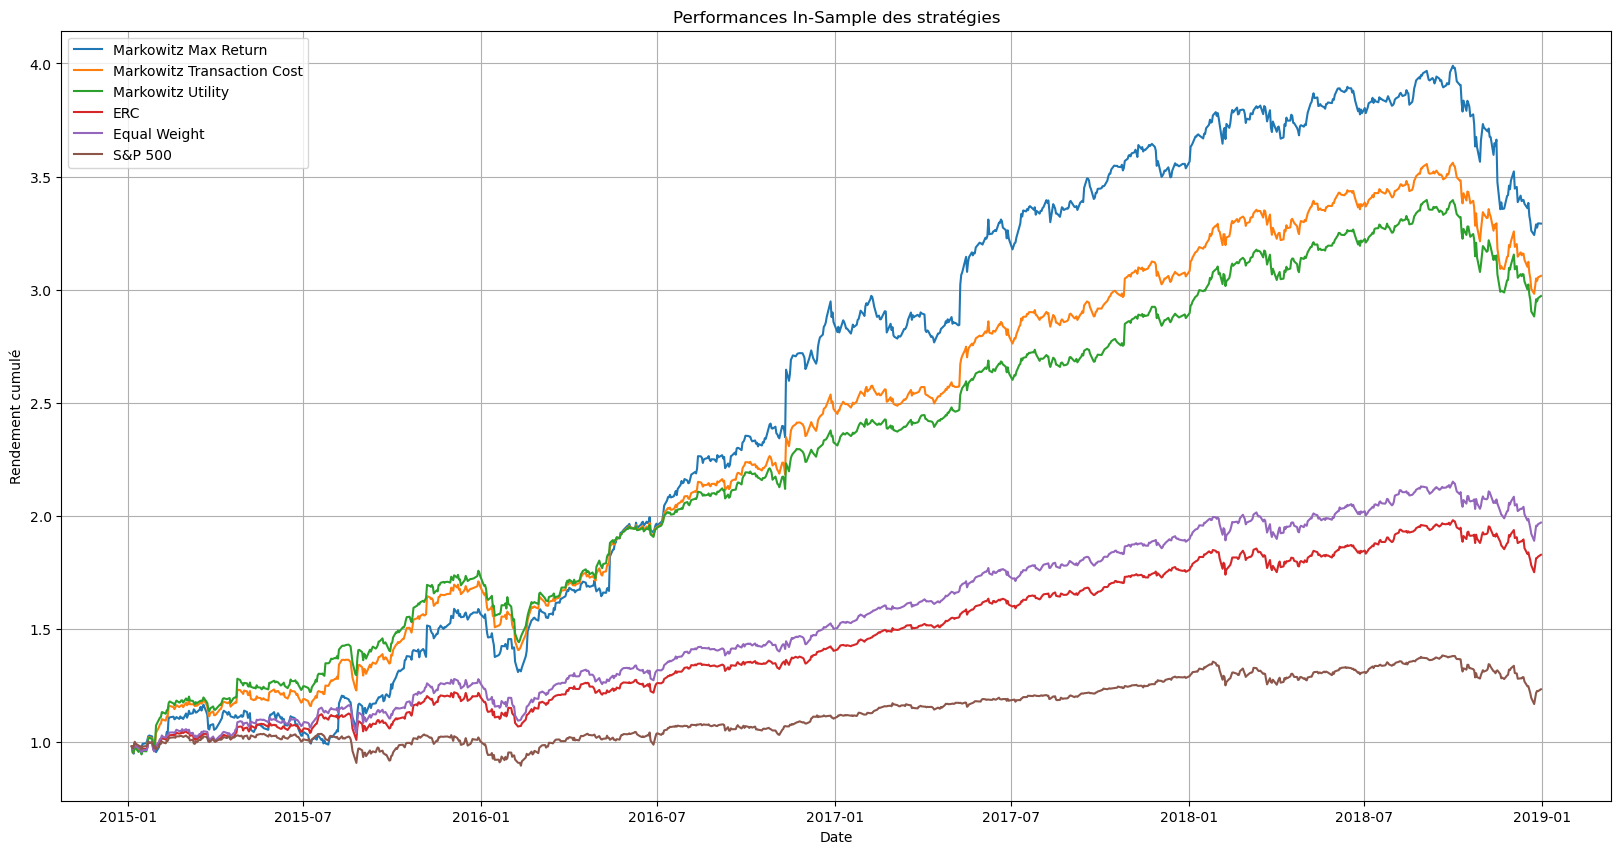

In [28]:
# 7.1 Visualisation des performances In-Sample
plt.figure(figsize=(20, 10))
for col in returns_in_cum.columns:
    plt.plot(1+returns_in_cum[col], label=col)
plt.title("Performances In-Sample des stratégies")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid()
plt.show()

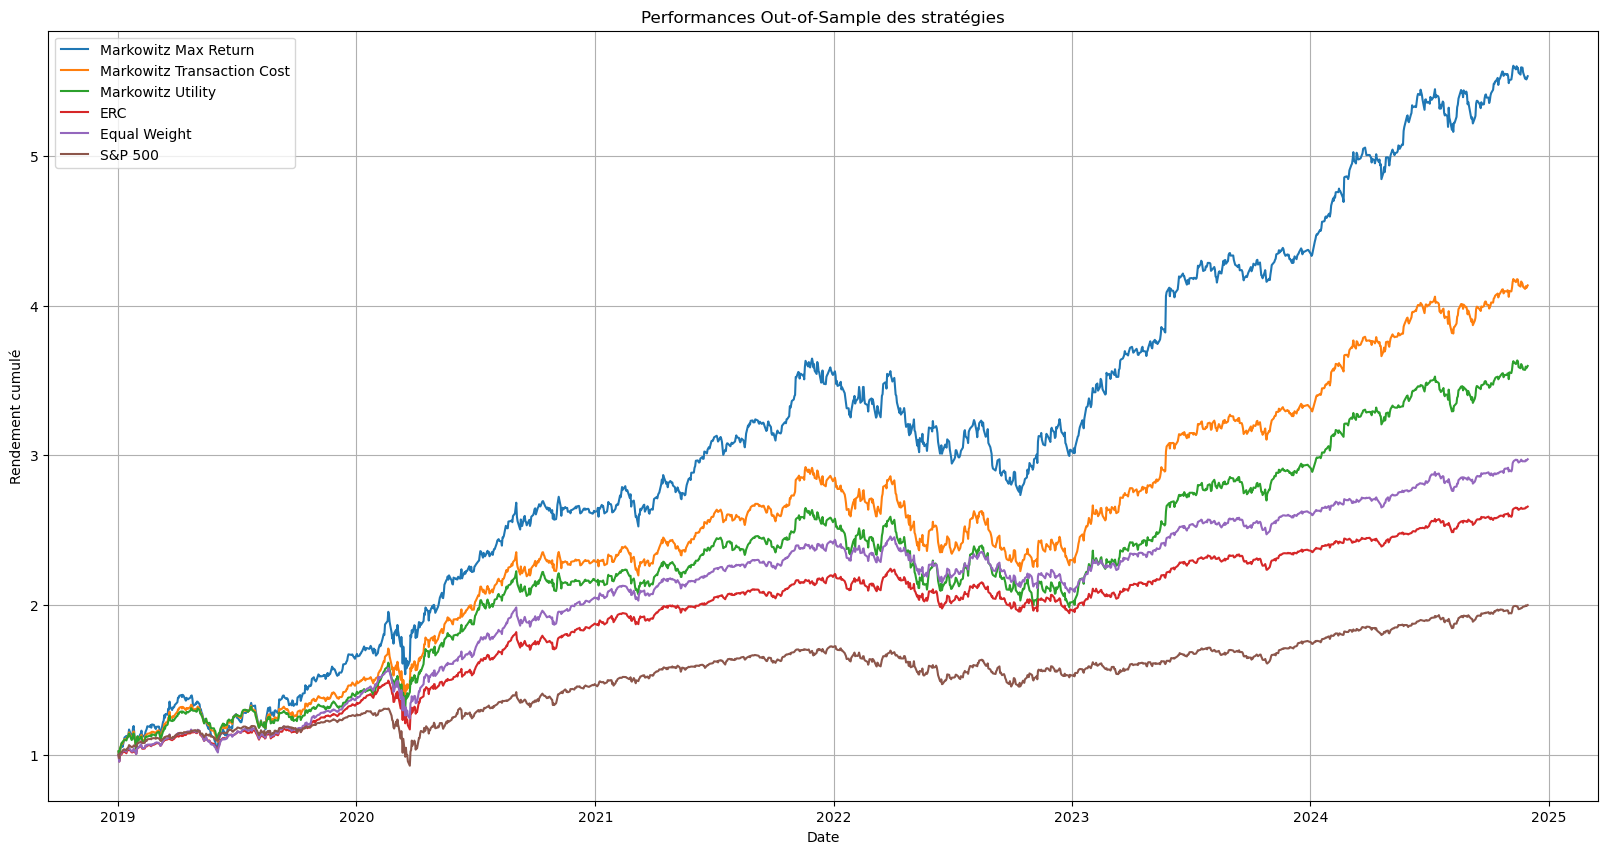

In [29]:
# 7.2 Visualisation des performances Out-of-Sample
plt.figure(figsize=(20, 10))
for col in returns_out_cum.columns:
    plt.plot(1+returns_out_cum[col], label=col)
plt.title("Performances Out-of-Sample des stratégies")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid()
plt.show()

In [20]:
# 8. Statistiques de performance
def performance_stats(returns):
    """
    Calcule les statistiques de performance :
    - Mean Return annualisé
    - Volatilité annualisée
    - Ratio de Sharpe
    - Cumulative Return
    """
    mean_return = returns.mean() * 252
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = mean_return / volatility
    cumulative_return = returns.sum()
    return {"Mean Return": mean_return, "Volatility": volatility, 
            "Sharpe Ratio": sharpe_ratio, "Cumulative Return": cumulative_return}

# Appliquer la fonction aux rendements journaliers
stats = pd.DataFrame({col: performance_stats(returns_out_cum[col].diff().dropna()) 
                      for col in returns_out_cum.columns}).T

# Afficher les statistiques
print("Statistiques de performance :")
stats


Statistiques de performance :


,Mean Return,Volatility,Sharpe Ratio,Cumulative Return
Markowitz Max Return,0.744719,0.532148,1.399460,2.904996
Markowitz Transaction Cost,0.378838,0.379323,0.998720,1.477768
Markowitz Utility,0.376993,0.378722,0.995435,1.470570
ERC,0.203276,0.194914,1.042900,0.792936
Equal Weight,0.238647,0.227827,1.047492,0.930912
S&P 500,0.138968,0.165360,0.840399,0.542086
